In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [2]:
np.random.seed(42)
n = 200  # Nombre de points de mesure

In [3]:
# Génération des KPI (0 ou 1 pour indiquer la présence ou l'absence de problèmes)
congestion_reseau = np.random.randint(0, 2, n)
interferences = np.random.randint(0, 2, n)
mauvaise_qualite_signal = np.random.randint(0, 2, n)
# Génération des valeurs aléatoires pour les KPI sans optimisation
latency_no_opt = np.random.normal(30, 7, n)  
throughput_no_opt = np.random.normal(30, 7, n) 
packet_loss_no_opt = np.random.normal(5, 0.75, n)  
connection_success_rate_no_opt = np.random.normal(80, 10, n)  

In [4]:
latency = (
    latency_no_opt
    + congestion_reseau *  np.abs(np.random.normal(10, 12, n))  # Augmente la latence si congestion
    + interferences * np.abs(np.random.normal(12, 3, n))  # Augmente la latence si interférences
    + mauvaise_qualite_signal * np.abs(np.random.normal(10, 5, n))  # Augmente la latence si mauvaise qualité du signal
)
throughput = (
    throughput_no_opt
    - congestion_reseau * np.abs(np.random.normal(15,9, n))  # Diminue le débit si congestion
    - interferences * np.abs(np.random.normal(1.5, 0.75, n))  # Diminue le débit si interférences
    - mauvaise_qualite_signal * np.abs(np.random.normal(2, 1.2, n))  # Diminue le débit si mauvaise qualité du signal
)
packet_loss = (
    packet_loss_no_opt
    + congestion_reseau * np.abs(np.random.normal(2, 1, n))  # Augmente la perte de paquets si congestion
    + interferences * np.abs(np.random.normal(1.5, 0.8, n))  # Augmente la perte de paquets si interférences
    + mauvaise_qualite_signal * np.abs(np.random.normal(2, 1, n))  # Augmente la perte de paquets si mauvaise qualité du signal
)
connection_success_rate = (
    connection_success_rate_no_opt
    - congestion_reseau * np.abs(np.random.normal(6, 5, n))  # Réduit le taux de réussite en cas de congestion
    - interferences * np.abs(np.random.normal(10, 12, n))  # Réduit le taux de réussite en cas d'interférences
    - mauvaise_qualite_signal * np.abs(np.random.normal(30, 20, n))  # Réduit le taux de réussite en cas de mauvaise qualité du signal
)

In [5]:
# --- Créer un dictionnaire avec les données ---
data1 = {
    "Latence (ms)": latency,
    "Débit (Mbps)": throughput,
    "Perte de paquets (%)": packet_loss,
    "Taux de réussite des connexions (%)": connection_success_rate
}
# Données des problèmes (KPI de congestion, interférences, et mauvaise qualité)
data2 = {
    'Congestion du réseau': congestion_reseau,
    'Interférences': interferences,
    'Mauvaise qualité du signal': mauvaise_qualite_signal
}

df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

# --- Affichage des DataFrames ---
print("Données des KPI dégradés :")
print(df1)    
data3 = {
    "Latence (ms)": latency_no_opt,
    "Débit (Mbps)": throughput_no_opt,
    "Perte de paquets (%)": packet_loss_no_opt,
    "Taux de réussite des connexions (%)":connection_success_rate_no_opt
}
df3 = pd.DataFrame(data3)
print("\nDonnées No dégradés :")
print(df3)  

Données des KPI dégradés :
     Latence (ms)  Débit (Mbps)  Perte de paquets (%)  \
0       44.621370     25.542523              7.078786   
1       70.028890      6.431241             11.244262   
2       45.007609     40.516499              4.240922   
3       34.437433     30.518663              3.758857   
4       41.613649     38.287204              9.202835   
..            ...           ...                   ...   
195     68.133793     -2.287601             10.541983   
196     70.311760     14.620123              8.954778   
197     65.384660     21.358421              7.570990   
198     47.063075     14.868961              6.025051   
199     21.493591     37.758102              5.386545   

     Taux de réussite des connexions (%)  
0                              61.375641  
1                              -2.323920  
2                              79.653151  
3                              82.342147  
4                              39.466716  
..                            

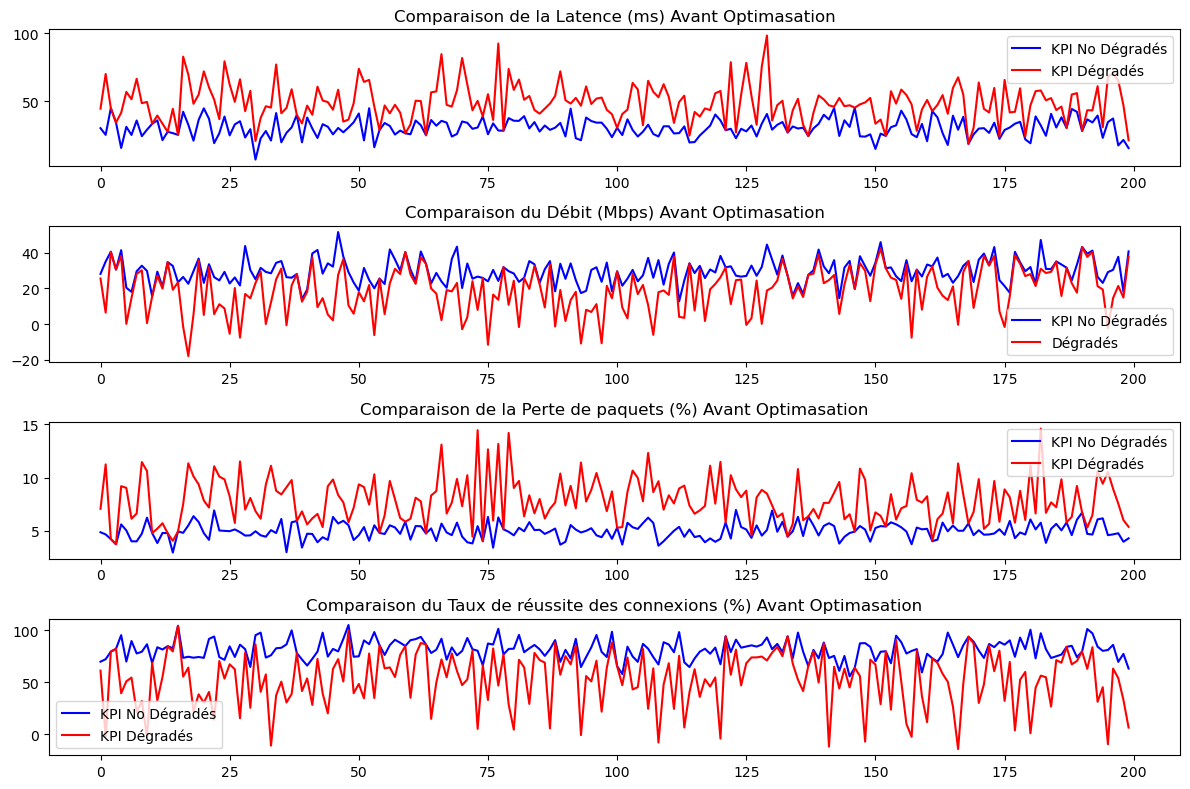

In [7]:
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(latency_no_opt, label='KPI No Dégradés', color='blue')
plt.plot(latency, label='KPI Dégradés', color='red')
plt.title('Comparaison de la Latence (ms) Avant Optimasation')
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(throughput_no_opt, label='KPI No Dégradés', color='blue')
plt.plot(throughput, label='Dégradés', color='red')
plt.title('Comparaison du Débit (Mbps) Avant Optimasation')
plt.legend()
plt.subplot(4, 1, 3)
plt.plot(packet_loss_no_opt, label='KPI No Dégradés', color='blue')
plt.plot(packet_loss, label='KPI Dégradés', color='red')
plt.title('Comparaison de la Perte de paquets (%) Avant Optimasation')
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(connection_success_rate_no_opt, label='KPI No Dégradés', color='blue')
plt.plot(connection_success_rate, label='KPI Dégradés', color='red')
plt.title('Comparaison du Taux de réussite des connexions (%) Avant Optimasation')
plt.legend()
plt.tight_layout()
plt.show()

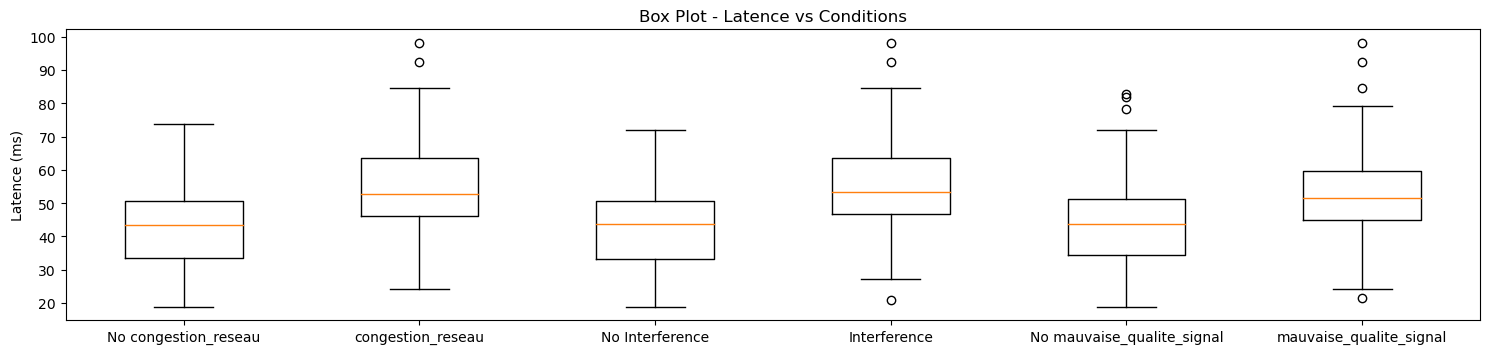

In [49]:
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
plt.boxplot([df1['Latence (ms)'][df2['Congestion du réseau'] == 0],
            df1['Latence (ms)'][df2['Congestion du réseau'] == 1],
            df1['Latence (ms)'][df2['Interférences'] == 0],
            df1['Latence (ms)'][df2['Interférences'] == 1],
            df1['Latence (ms)'][df2['Mauvaise qualité du signal'] == 0],
            df1['Latence (ms)'][df2['Mauvaise qualité du signal'] == 1]],
            labels=['No congestion_reseau', 'congestion_reseau', 'No Interference', 'Interference', 'No mauvaise_qualite_signal', 'mauvaise_qualite_signal'])
plt.title('Box Plot - Latence vs Conditions')
plt.ylabel('Latence (ms)')
plt.tight_layout()
plt.show()

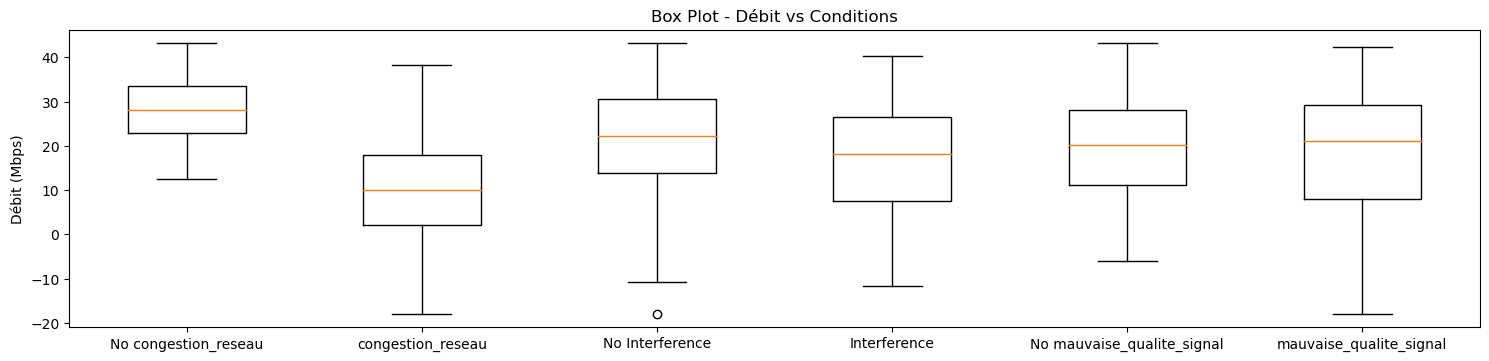

In [50]:
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 2)
plt.boxplot([df1['Débit (Mbps)'][df2['Congestion du réseau'] == 0],
            df1['Débit (Mbps)'][df2['Congestion du réseau'] == 1],
            df1['Débit (Mbps)'][df2['Interférences'] == 0],
            df1['Débit (Mbps)'][df2['Interférences'] == 1],
            df1['Débit (Mbps)'][df2['Mauvaise qualité du signal'] == 0],
            df1['Débit (Mbps)'][df2['Mauvaise qualité du signal'] == 1]],
            labels=['No congestion_reseau', 'congestion_reseau', 'No Interference', 'Interference', 'No mauvaise_qualite_signal', 'mauvaise_qualite_signal'])
plt.title('Box Plot - Débit vs Conditions')
plt.ylabel('Débit (Mbps)')
# Afficher les graphiques
plt.tight_layout()
plt.show()

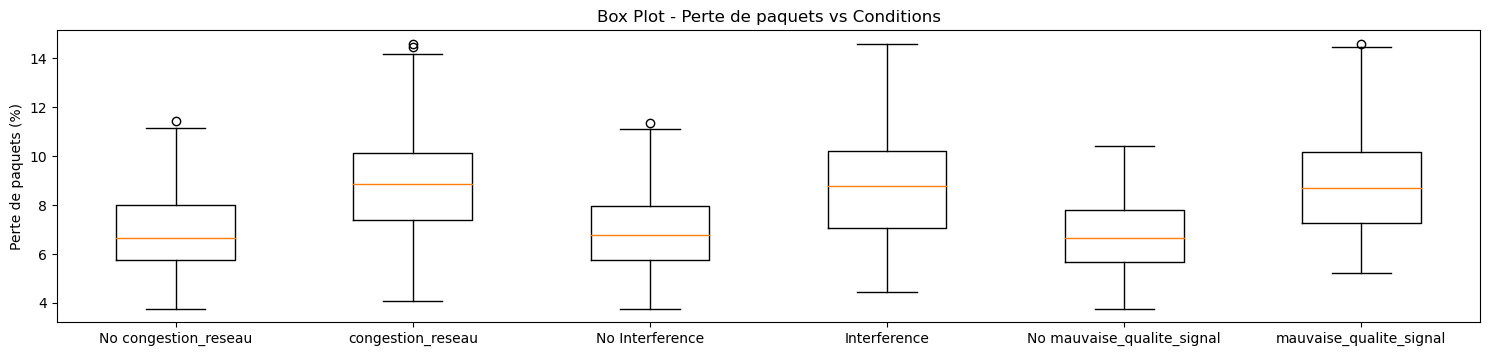

In [51]:
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 3)
plt.boxplot([df1['Perte de paquets (%)'][df2['Congestion du réseau'] == 0],
            df1['Perte de paquets (%)'][df2['Congestion du réseau'] == 1],
            df1['Perte de paquets (%)'][df2['Interférences'] == 0],
            df1['Perte de paquets (%)'][df2['Interférences'] == 1],
            df1['Perte de paquets (%)'][df2['Mauvaise qualité du signal'] == 0],
            df1['Perte de paquets (%)'][df2['Mauvaise qualité du signal'] == 1]],
            labels=['No congestion_reseau', 'congestion_reseau', 'No Interference', 'Interference', 'No mauvaise_qualite_signal', 'mauvaise_qualite_signal'])
plt.title('Box Plot - Perte de paquets vs Conditions')
plt.ylabel('Perte de paquets (%)')
plt.tight_layout()
plt.show()


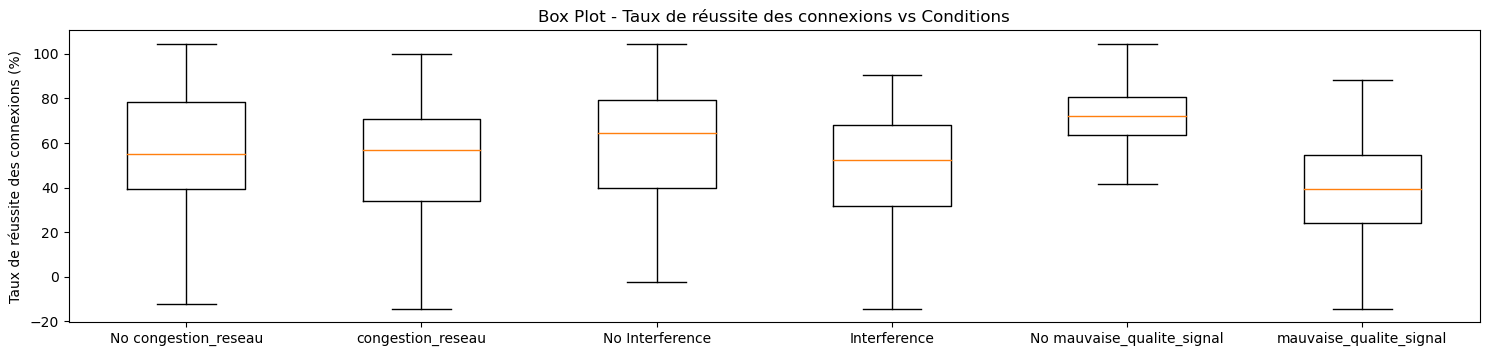

In [52]:
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 3)
plt.boxplot([df1['Taux de réussite des connexions (%)'][df2['Congestion du réseau'] == 0],
            df1['Taux de réussite des connexions (%)'][df2['Congestion du réseau'] == 1],
            df1['Taux de réussite des connexions (%)'][df2['Interférences'] == 0],
            df1['Taux de réussite des connexions (%)'][df2['Interférences'] == 1],
            df1['Taux de réussite des connexions (%)'][df2['Mauvaise qualité du signal'] == 0],
            df1['Taux de réussite des connexions (%)'][df2['Mauvaise qualité du signal'] == 1]],
            labels=['No congestion_reseau', 'congestion_reseau', 'No Interference', 'Interference', 'No mauvaise_qualite_signal', 'mauvaise_qualite_signal'])
plt.title('Box Plot - Taux de réussite des connexions vs Conditions')
plt.ylabel('Taux de réussite des connexions (%)')
plt.tight_layout()
plt.show()

In [55]:
print("\nDonnées des problèmes (KPI) :")
print(df2)


Données des problèmes (KPI) :
     Congestion du réseau  Interférences  Mauvaise qualité du signal
0                       0              0                           1
1                       1              1                           1
2                       0              0                           0
3                       0              0                           0
4                       0              1                           1
..                    ...            ...                         ...
195                     1              1                           1
196                     1              1                           0
197                     1              1                           0
198                     0              1                           1
199                     0              0                           1

[200 rows x 3 columns]


In [ ]:
# Détection du problème
problemes = [] 
for i in range(n):
    problem_list = []
    
    if data2['Congestion du réseau'][i] == 1:
        problem_list.append('Congestion')
    if data2['Interférences'][i] == 1:
        problem_list.append('Interférences')
    if data2['Mauvaise qualité du signal'][i] == 1:
        problem_list.append('Mauvaise qualité du signal')
    
    # Si aucun problème n'est détecté, on ajoute "Aucun problème détecté"
    if not problem_list:
        problem_list.append('Aucun problème détecté')

    problemes.append(', '.join(problem_list))  # Joindre les problèmes multiples avec une virgule

# Ajout des problèmes détectés dans les données
data2['Problème'] = problemes

# --- Ajustement automatique des paramètres réseau ---
def ajuster_parametres(probleme):
    ajustements = {"Puissance d'émission": 0, "Allocation des fréquences": 0, "Bandes passantes": 0, "Modulation and Coding Scheme": 0}
    
    if 'Congestion' in probleme:
        ajustements["Puissance d'émission"] = "30 dBm --> 40 dBm"
        ajustements["Allocation des fréquences"] = "800 MHz --> 900 MHz"
        ajustements["Bandes passantes"] = "20 MHz --> 10 MHz"
        ajustements["Modulation and Coding Scheme"] = "(256-QAM) --> (16-QAM)"
        
    if 'Interférences' in probleme:
        ajustements["Puissance d'émission"] = "38 dBm --> 35 dBm"
        ajustements["Allocation des fréquences"] = "800 MHz --> 900 MHz"
        ajustements["Bandes passantes"] = "5 MHz --> 5 MHz"
        ajustements["Modulation and Coding Scheme"] = "(256-QAM, 3/4 FEC) --> (QPSK, 1/2 FEC)"
    
    if 'Mauvaise qualité du signal' in probleme:
        ajustements["Puissance d'émission"] = "30 dBm --> 40 dBm"
        ajustements["Allocation des fréquences"] = "0 --> 900 MHz"
        ajustements["Bandes passantes"] = "20 MHz --> 10 MHz"
        ajustements["Modulation and Coding Scheme"] = "(256-QAM, 3/4 FEC) --> (QPSK, 1/2 FEC)"
    
    return ajustements

print("Détection et ajustement des problèmes, étape par étape.")
for i, probleme in enumerate(data2['Problème']):
    ajustements = ajuster_parametres(probleme)
    print(f"\nÉtape {i} :")
    print(f"Problème détecté : {probleme}")
    print(f"Paramètres ajustés : {ajustements}")
    input("Appuyez sur Entrée pour continuer...")


Détection et ajustement des problèmes, étape par étape.

Étape 0 :
Problème détecté : Mauvaise qualité du signal
Paramètres ajustés : {"Puissance d'émission": '30 dBm --> 40 dBm', 'Allocation des fréquences': '0 --> 900 MHz', 'Bandes passantes': '20 MHz --> 10 MHz', 'Modulation and Coding Scheme': '(256-QAM, 3/4 FEC) --> (QPSK, 1/2 FEC)'}
Appuyez sur Entrée pour continuer...

Étape 1 :
Problème détecté : Congestion, Interférences, Mauvaise qualité du signal
Paramètres ajustés : {"Puissance d'émission": '30 dBm --> 40 dBm', 'Allocation des fréquences': '0 --> 900 MHz', 'Bandes passantes': '20 MHz --> 10 MHz', 'Modulation and Coding Scheme': '(256-QAM, 3/4 FEC) --> (QPSK, 1/2 FEC)'}
Appuyez sur Entrée pour continuer...

Étape 2 :
Problème détecté : Aucun problème détecté
Paramètres ajustés : {"Puissance d'émission": 0, 'Allocation des fréquences': 0, 'Bandes passantes': 0, 'Modulation and Coding Scheme': 0}
Appuyez sur Entrée pour continuer...

Étape 3 :
Problème détecté : Aucun problème

In [30]:
X_time = np.array(range(n)).reshape(-1, 1)
latency_model = XGBRegressor()
throughput_model = XGBRegressor()
packet_loss_model = XGBRegressor()
connection_success_rate_model = XGBRegressor()

latency_model.fit(X_time, latency_no_opt)
throughput_model.fit(X_time, throughput_no_opt)
packet_loss_model.fit(X_time, packet_loss_no_opt)
connection_success_rate_model.fit(X_time,connection_success_rate_no_opt)
# Prédictions après optimisation
latency_optimized = latency_model.predict(X_time)
throughput_optimized = throughput_model.predict(X_time)
packet_loss_optimized = packet_loss_model.predict(X_time)
connection_success_rate_optimized = connection_success_rate_model.predict(X_time)

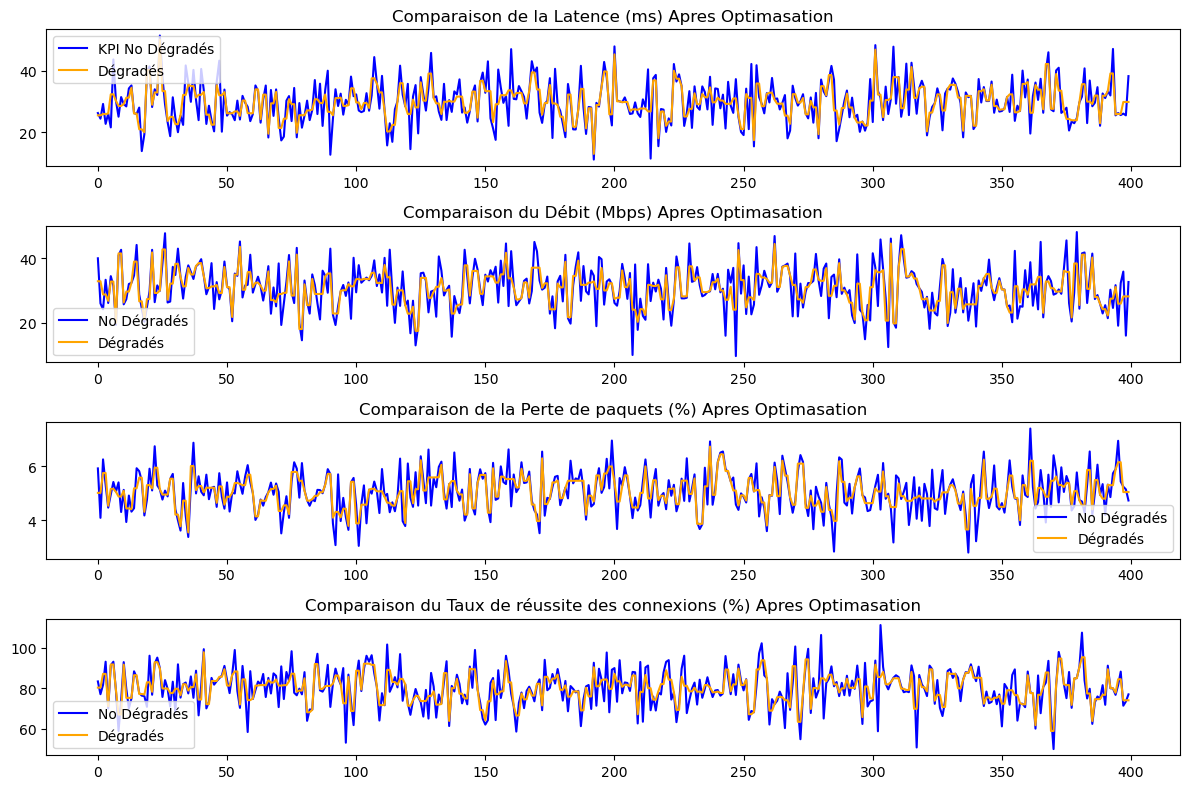

In [31]:
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(latency_no_opt, label='KPI No Dégradés', color='blue')
plt.plot(latency_optimized, label='Dégradés', color='orange')
plt.title('Comparaison de la Latence (ms) Apres Optimasation')
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(throughput_no_opt, label='No Dégradés', color='blue')
plt.plot(throughput_optimized, label='Dégradés', color='orange')
plt.title('Comparaison du Débit (Mbps) Apres Optimasation')
plt.legend()
plt.subplot(4, 1, 3)
plt.plot(packet_loss_no_opt, label='No Dégradés', color='blue')
plt.plot(packet_loss_optimized, label='Dégradés', color='orange')
plt.title('Comparaison de la Perte de paquets (%) Apres Optimasation')
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(connection_success_rate_no_opt, label='No Dégradés', color='blue')
plt.plot(connection_success_rate_optimized, label='Dégradés', color='orange')
plt.title('Comparaison du Taux de réussite des connexions (%) Apres Optimasation')
plt.legend()
plt.tight_layout()
plt.show()

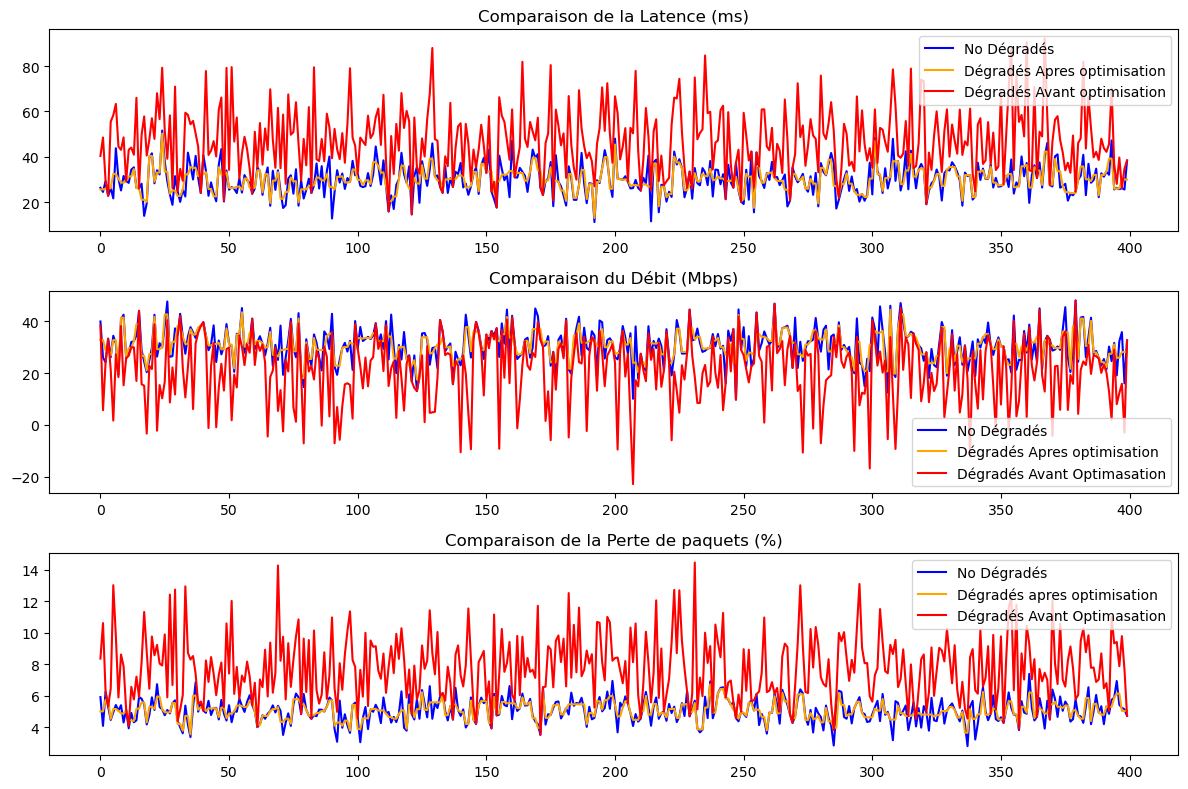

Erreur quadratique moyenne pour la latence : 18.713098201670917
Erreur quadratique moyenne pour le débit : 18.92328847766232
Erreur quadratique moyenne pour la perte de paquets : 0.2150330941511024


In [32]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(latency_no_opt, label='No Dégradés', color='blue')
plt.plot(latency_optimized, label='Dégradés Apres optimisation', color='orange')
plt.plot(latency, label='Dégradés Avant optimisation', color='red')
plt.title('Comparaison de la Latence (ms)')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(throughput_no_opt, label='No Dégradés', color='blue')
plt.plot(throughput_optimized, label='Dégradés Apres optimisation', color='orange')
plt.plot(throughput, label='Dégradés Avant Optimasation', color='red')
plt.title('Comparaison du Débit (Mbps)')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(packet_loss_no_opt, label='No Dégradés', color='blue')
plt.plot(packet_loss_optimized, label='Dégradés apres optimisation', color='orange')
plt.plot(packet_loss, label='Dégradés Avant Optimasation', color='red')
plt.title('Comparaison de la Perte de paquets (%)')
plt.legend()
plt.tight_layout()
plt.show()
# Calcul de l'erreur quadratique moyenne (MSE) pour chaque modèle
latency_mse = mean_squared_error(latency_no_opt, latency_optimized)
throughput_mse = mean_squared_error(throughput_no_opt, throughput_optimized)
packet_loss_mse = mean_squared_error(packet_loss_no_opt, packet_loss_optimized)
connection_success_rate_mse = mean_squared_error(connection_success_rate_no_opt, connection_success_rate_optimized)
# Affichage des erreurs quadratiques moyennes
print(f"Erreur quadratique moyenne pour la latence : {latency_mse}")
print(f"Erreur quadratique moyenne pour le débit : {throughput_mse}")
print(f"Erreur quadratique moyenne pour la perte de paquets : {packet_loss_mse}")

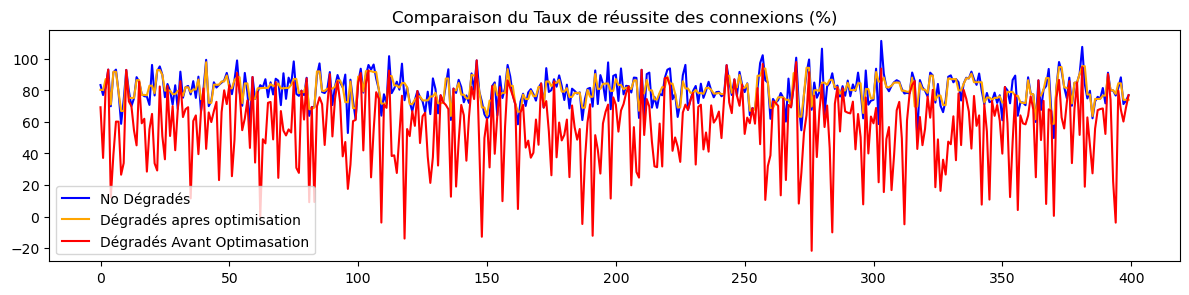

Erreur quadratique moyenne pour la latence : 18.713098201670917
Erreur quadratique moyenne pour le débit : 18.92328847766232
Erreur quadratique moyenne pour la perte de paquets : 0.2150330941511024
Erreur quadratique moyenne pour le taux de réussite des connexions : 38.387516793308


In [33]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 2)
plt.plot(connection_success_rate_no_opt, label='No Dégradés', color='blue')
plt.plot(connection_success_rate_optimized, label='Dégradés apres optimisation', color='orange')
plt.plot(connection_success_rate, label='Dégradés Avant Optimasation', color='red')
plt.title('Comparaison du Taux de réussite des connexions (%)')
plt.legend()
plt.tight_layout()
plt.show()
print(f"Erreur quadratique moyenne pour la latence : {latency_mse}")
print(f"Erreur quadratique moyenne pour le débit : {throughput_mse}")
print(f"Erreur quadratique moyenne pour la perte de paquets : {packet_loss_mse}")
print(f"Erreur quadratique moyenne pour le taux de réussite des connexions : {connection_success_rate_mse}")

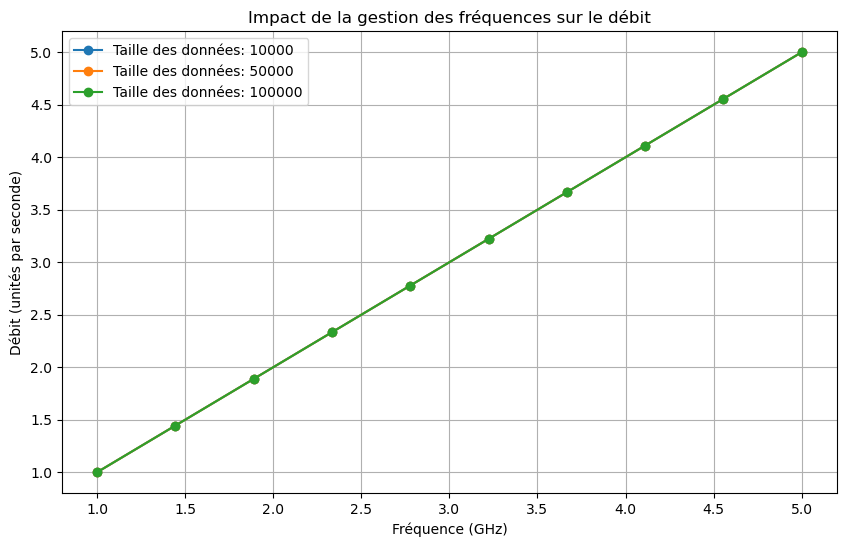

In [16]:
import time
import matplotlib.pyplot as plt
import numpy as np

# Simulation de gestion des fréquences

def compute_throughput(frequency, data_size):
    """
    Simule le débit en fonction de la fréquence et de la taille des données.
    Plus la fréquence est élevée, plus le débit est important.
    """
    base_latency = 1 / frequency  # Latence de base inversement proportionnelle à la fréquence
    processing_time = base_latency * data_size  # Temps total pour traiter les données
    throughput = data_size / processing_time  # Débit = taille des données / temps de traitement
    return throughput

# Fréquences simulées (en GHz)
frequencies = np.linspace(1.0, 5.0, 10)  # Fréquences de 1 GHz à 5 GHz
# Taille des données (en unités arbitraires)
data_sizes = [10_000, 50_000, 100_000]

# Calcul des débits pour chaque taille de données et fréquence
throughputs = {size: [] for size in data_sizes}
for freq in frequencies:
    for size in data_sizes:
        throughputs[size].append(compute_throughput(freq, size))

# Tracer le graphe
plt.figure(figsize=(10, 6))
for size, throughput in throughputs.items():
    plt.plot(frequencies, throughput, label=f"Taille des données: {size}", marker="o")

plt.title("Impact de la gestion des fréquences sur le débit")
plt.xlabel("Fréquence (GHz)")
plt.ylabel("Débit (unités par seconde)")
plt.legend()
plt.grid()
plt.show()


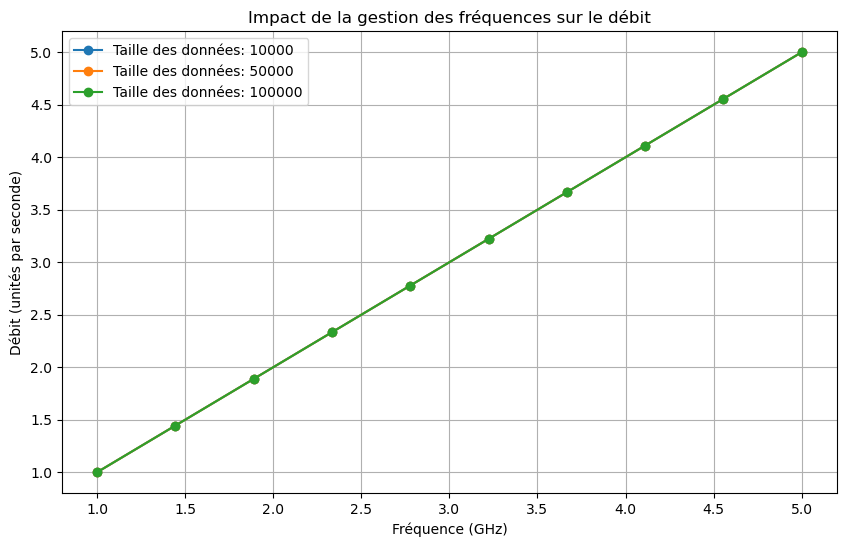

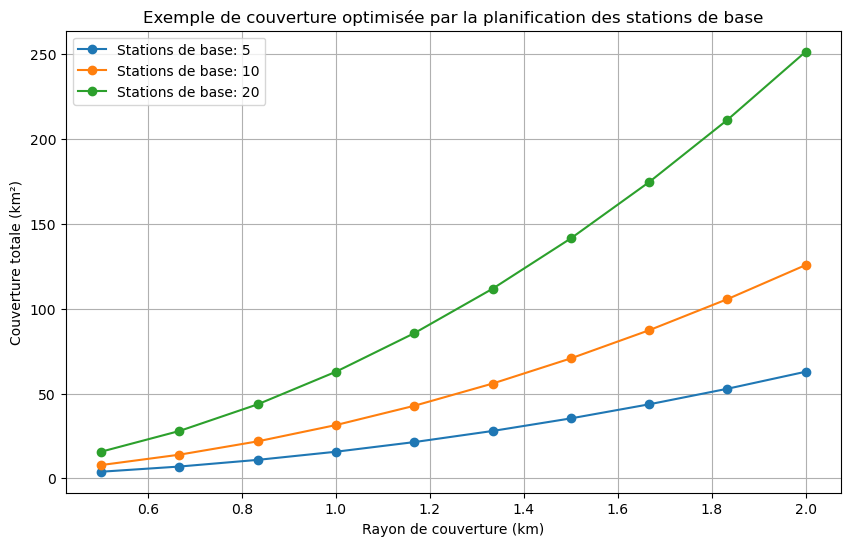

In [17]:
import time
import matplotlib.pyplot as plt
import numpy as np

# Simulation de gestion des fréquences

def compute_throughput(frequency, data_size):
    """
    Simule le débit en fonction de la fréquence et de la taille des données.
    Plus la fréquence est élevée, plus le débit est important.
    """
    base_latency = 1 / frequency  # Latence de base inversement proportionnelle à la fréquence
    processing_time = base_latency * data_size  # Temps total pour traiter les données
    throughput = data_size / processing_time  # Débit = taille des données / temps de traitement
    return throughput

# Fréquences simulées (en GHz)
frequencies = np.linspace(1.0, 5.0, 10)  # Fréquences de 1 GHz à 5 GHz
# Taille des données (en unités arbitraires)
data_sizes = [10_000, 50_000, 100_000]

# Calcul des débits pour chaque taille de données et fréquence
throughputs = {size: [] for size in data_sizes}
for freq in frequencies:
    for size in data_sizes:
        throughputs[size].append(compute_throughput(freq, size))

# Tracer le graphe
plt.figure(figsize=(10, 6))
for size, throughput in throughputs.items():
    plt.plot(frequencies, throughput, label=f"Taille des données: {size}", marker="o")

plt.title("Impact de la gestion des fréquences sur le débit")
plt.xlabel("Fréquence (GHz)")
plt.ylabel("Débit (unités par seconde)")
plt.legend()
plt.grid()
plt.show()

# Simulation de couverture optimisée par la planification des stations de base

def compute_coverage(radius, base_stations):
    """
    Simule la couverture en fonction du rayon de chaque station de base et du nombre de stations.
    La couverture totale est approximée par l'aire couverte.
    """
    area_per_station = np.pi * radius**2  # Aire couverte par une station (cercle)
    total_coverage = base_stations * area_per_station  # Couverture totale
    return total_coverage

# Rayons simulés (en km)
radii = np.linspace(0.5, 2.0, 10)  # Rayons de 0,5 km à 2 km
# Nombre de stations de base simulées
base_station_counts = [5, 10, 20]

# Calcul des couvertures pour chaque rayon et nombre de stations
total_coverages = {count: [] for count in base_station_counts}
for radius in radii:
    for count in base_station_counts:
        total_coverages[count].append(compute_coverage(radius, count))

# Tracer le graphe
plt.figure(figsize=(10, 6))
for count, coverage in total_coverages.items():
    plt.plot(radii, coverage, label=f"Stations de base: {count}", marker="o")

plt.title("Exemple de couverture optimisée par la planification des stations de base")
plt.xlabel("Rayon de couverture (km)")
plt.ylabel("Couverture totale (km²)")
plt.legend()
plt.grid()
plt.show()


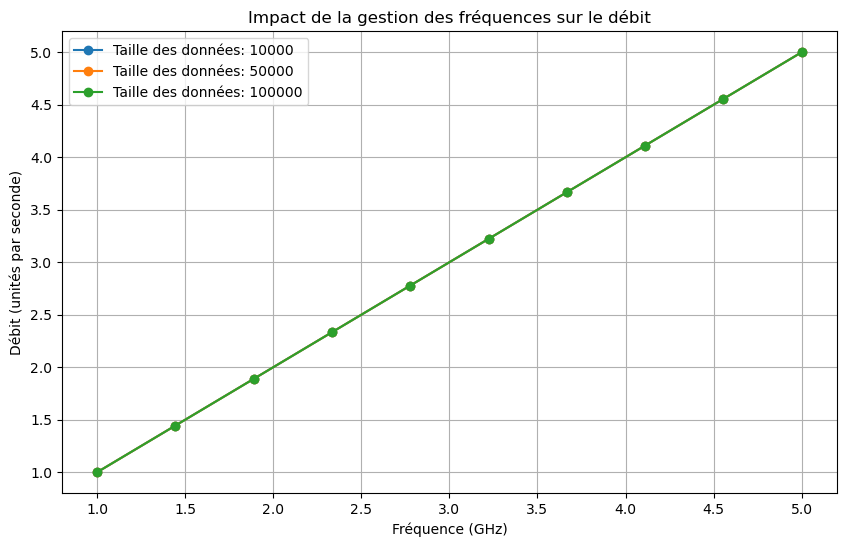

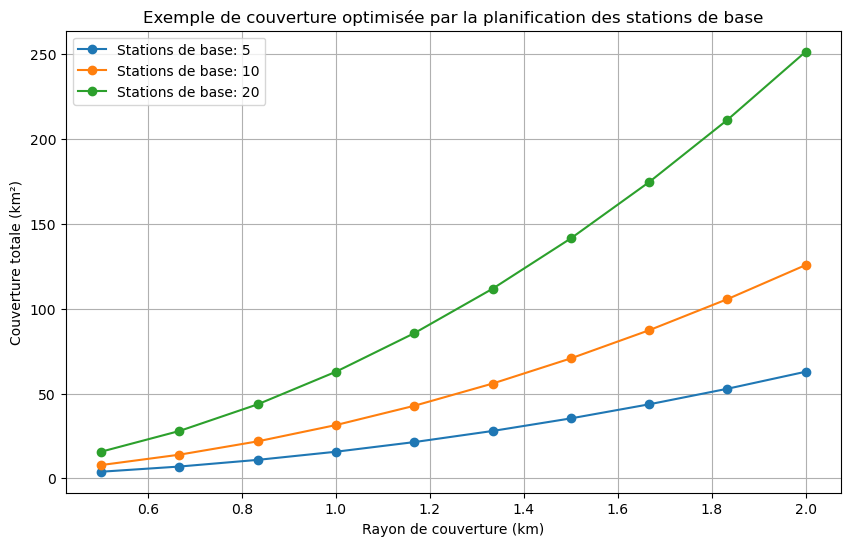

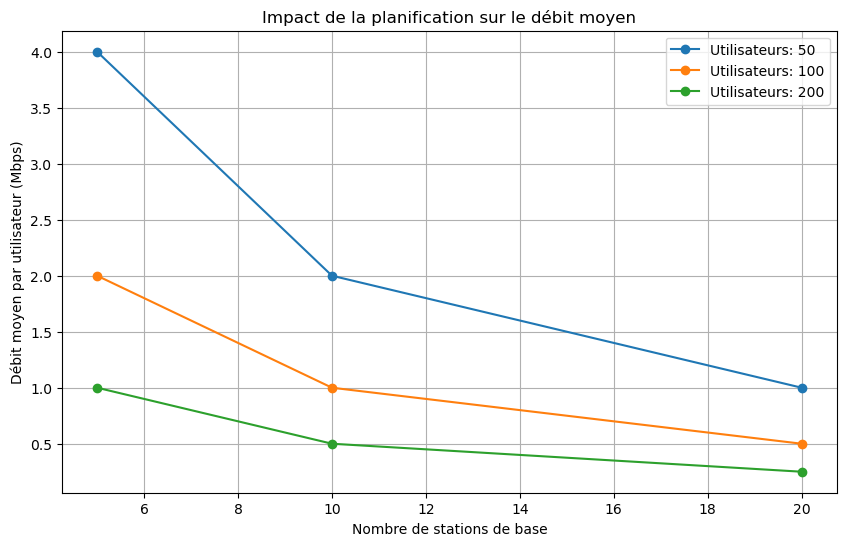

In [18]:
import time
import matplotlib.pyplot as plt
import numpy as np

# Simulation de gestion des fréquences

def compute_throughput(frequency, data_size):
    """
    Simule le débit en fonction de la fréquence et de la taille des données.
    Plus la fréquence est élevée, plus le débit est important.
    """
    base_latency = 1 / frequency  # Latence de base inversement proportionnelle à la fréquence
    processing_time = base_latency * data_size  # Temps total pour traiter les données
    throughput = data_size / processing_time  # Débit = taille des données / temps de traitement
    return throughput

# Fréquences simulées (en GHz)
frequencies = np.linspace(1.0, 5.0, 10)  # Fréquences de 1 GHz à 5 GHz
# Taille des données (en unités arbitraires)
data_sizes = [10_000, 50_000, 100_000]

# Calcul des débits pour chaque taille de données et fréquence
throughputs = {size: [] for size in data_sizes}
for freq in frequencies:
    for size in data_sizes:
        throughputs[size].append(compute_throughput(freq, size))

# Tracer le graphe
plt.figure(figsize=(10, 6))
for size, throughput in throughputs.items():
    plt.plot(frequencies, throughput, label=f"Taille des données: {size}", marker="o")

plt.title("Impact de la gestion des fréquences sur le débit")
plt.xlabel("Fréquence (GHz)")
plt.ylabel("Débit (unités par seconde)")
plt.legend()
plt.grid()
plt.show()

# Simulation de couverture optimisée par la planification des stations de base

def compute_coverage(radius, base_stations):
    """
    Simule la couverture en fonction du rayon de chaque station de base et du nombre de stations.
    La couverture totale est approximée par l'aire couverte.
    """
    area_per_station = np.pi * radius**2  # Aire couverte par une station (cercle)
    total_coverage = base_stations * area_per_station  # Couverture totale
    return total_coverage

# Rayons simulés (en km)
radii = np.linspace(0.5, 2.0, 10)  # Rayons de 0,5 km à 2 km
# Nombre de stations de base simulées
base_station_counts = [5, 10, 20]

# Calcul des couvertures pour chaque rayon et nombre de stations
total_coverages = {count: [] for count in base_station_counts}
for radius in radii:
    for count in base_station_counts:
        total_coverages[count].append(compute_coverage(radius, count))

# Tracer le graphe
plt.figure(figsize=(10, 6))
for count, coverage in total_coverages.items():
    plt.plot(radii, coverage, label=f"Stations de base: {count}", marker="o")

plt.title("Exemple de couverture optimisée par la planification des stations de base")
plt.xlabel("Rayon de couverture (km)")
plt.ylabel("Couverture totale (km²)")
plt.legend()
plt.grid()
plt.show()

# Simulation de l'impact de la planification sur le débit moyen

def compute_average_throughput(base_stations, users, bandwidth):
    """
    Simule le débit moyen par utilisateur en fonction du nombre de stations de base,
    du nombre d'utilisateurs et de la bande passante totale disponible.
    """
    total_bandwidth_per_station = bandwidth / base_stations  # Bande passante par station
    average_throughput = total_bandwidth_per_station / users  # Débit moyen par utilisateur
    return average_throughput

# Paramètres simulés
base_station_counts = [5, 10, 20]  # Nombre de stations de base
user_counts = [50, 100, 200]  # Nombre d'utilisateurs par station
bandwidth = 1000  # Bande passante totale disponible (en Mbps)

# Calcul des débits moyens
average_throughputs = {users: [] for users in user_counts}
for stations in base_station_counts:
    for users in user_counts:
        average_throughputs[users].append(compute_average_throughput(stations, users, bandwidth))

# Tracer le graphe
plt.figure(figsize=(10, 6))
for users, throughputs in average_throughputs.items():
    plt.plot(base_station_counts, throughputs, label=f"Utilisateurs: {users}", marker="o")

plt.title("Impact de la planification sur le débit moyen")
plt.xlabel("Nombre de stations de base")
plt.ylabel("Débit moyen par utilisateur (Mbps)")
plt.legend()
plt.grid()
plt.show()

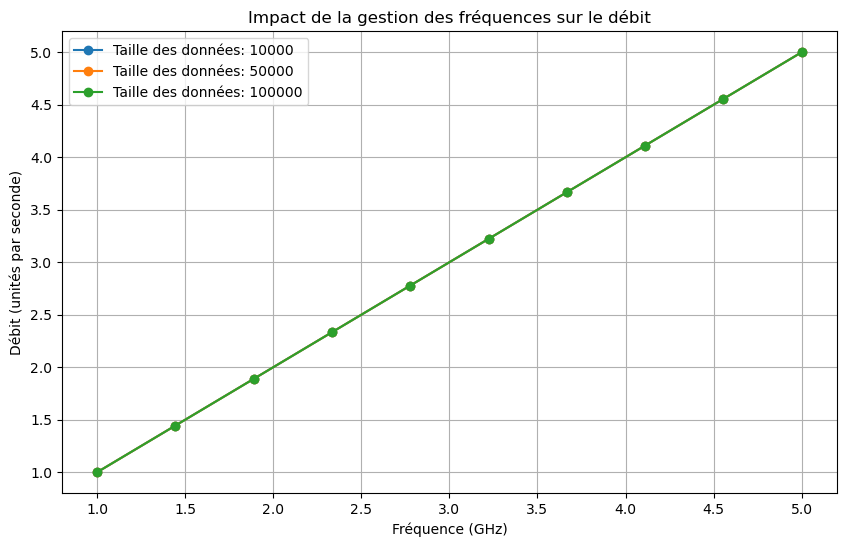

In [19]:
import time
import matplotlib.pyplot as plt
import numpy as np

# Simulation de gestion des fréquences

def compute_throughput(frequency, data_size):
    """
    Simule le débit en fonction de la fréquence et de la taille des données.
    Plus la fréquence est élevée, plus le débit est important.
    """
    base_latency = 1 / frequency  # Latence de base inversement proportionnelle à la fréquence
    processing_time = base_latency * data_size  # Temps total pour traiter les données
    throughput = data_size / processing_time  # Débit = taille des données / temps de traitement
    return throughput

# Fréquences simulées (en GHz)
frequencies = np.linspace(1.0, 5.0, 10)  # Fréquences de 1 GHz à 5 GHz
# Taille des données (en unités arbitraires)
data_sizes = [10_000, 50_000, 100_000]

# Calcul des débits pour chaque taille de données et fréquence
throughputs = {size: [] for size in data_sizes}
for freq in frequencies:
    for size in data_sizes:
        throughputs[size].append(compute_throughput(freq, size))

# Tracer le graphe
plt.figure(figsize=(10, 6))
for size, throughput in throughputs.items():
    plt.plot(frequencies, throughput, label=f"Taille des données: {size}", marker="o")

plt.title("Impact de la gestion des fréquences sur le débit")
plt.xlabel("Fréquence (GHz)")
plt.ylabel("Débit (unités par seconde)")
plt.legend()
plt.grid()
plt.show()

# Simulation de couverture optimisée par la planification des stations de base

def compute_coverage(radius, base_stations):
    """
    Simule la couverture en fonction du rayon de chaque station de base et du nombre de stations.
    La couverture totale est approximée par l'aire couverte.
    """

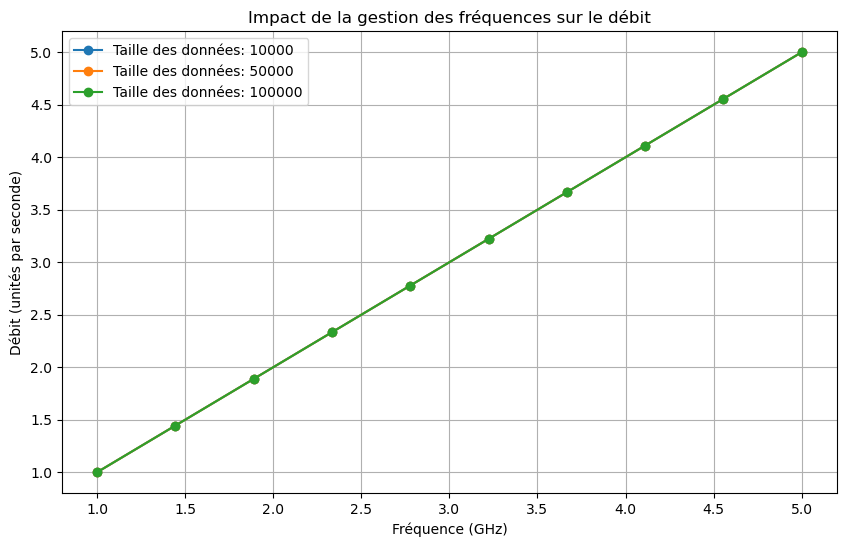

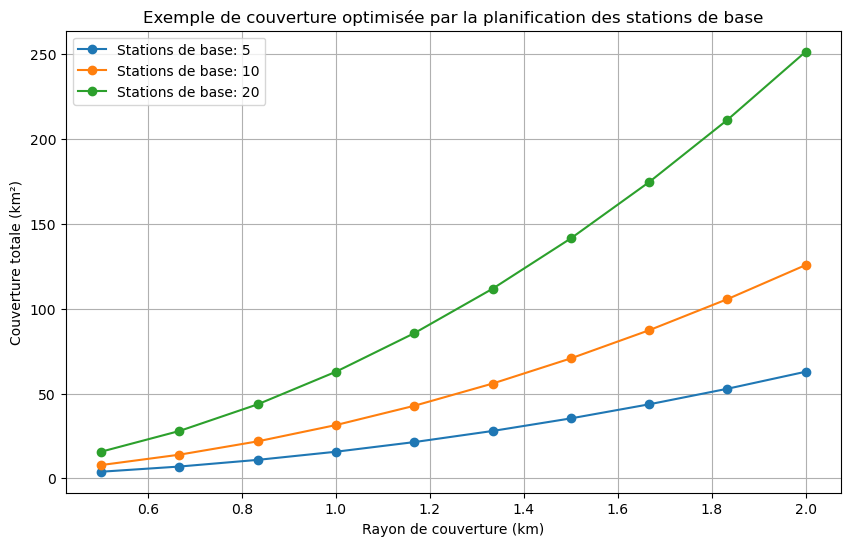

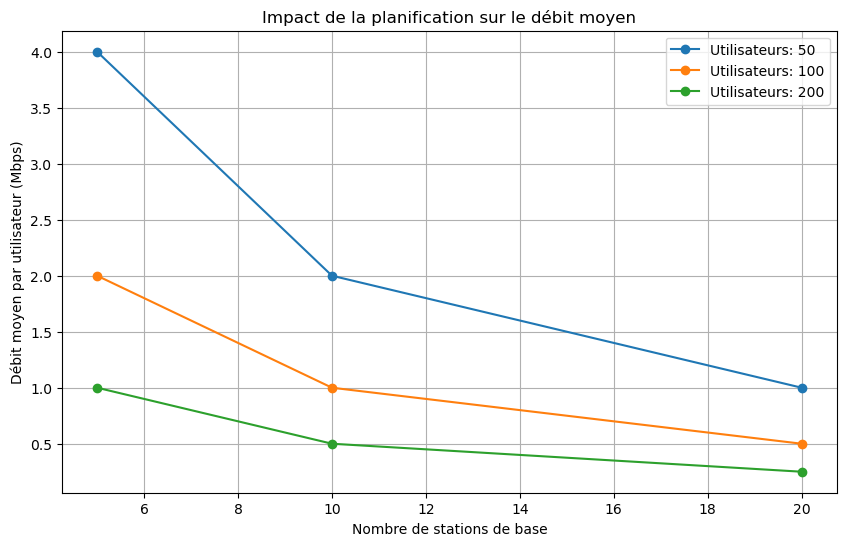

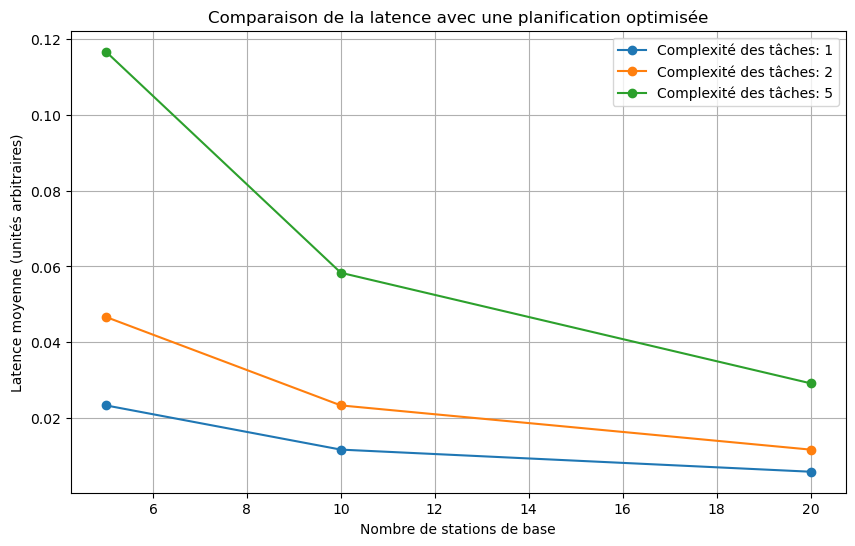

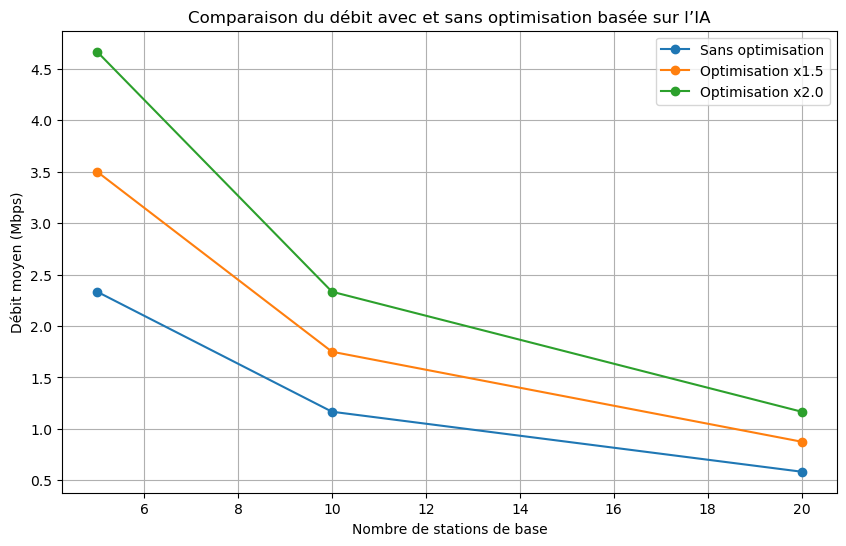

In [20]:
import time
import matplotlib.pyplot as plt
import numpy as np

# Simulation de gestion des fréquences

def compute_throughput(frequency, data_size):
    """
    Simule le débit en fonction de la fréquence et de la taille des données.
    Plus la fréquence est élevée, plus le débit est important.
    """
    base_latency = 1 / frequency  # Latence de base inversement proportionnelle à la fréquence
    processing_time = base_latency * data_size  # Temps total pour traiter les données
    throughput = data_size / processing_time  # Débit = taille des données / temps de traitement
    return throughput

# Fréquences simulées (en GHz)
frequencies = np.linspace(1.0, 5.0, 10)  # Fréquences de 1 GHz à 5 GHz
# Taille des données (en unités arbitraires)
data_sizes = [10_000, 50_000, 100_000]

# Calcul des débits pour chaque taille de données et fréquence
throughputs = {size: [] for size in data_sizes}
for freq in frequencies:
    for size in data_sizes:
        throughputs[size].append(compute_throughput(freq, size))

# Tracer le graphe
plt.figure(figsize=(10, 6))
for size, throughput in throughputs.items():
    plt.plot(frequencies, throughput, label=f"Taille des données: {size}", marker="o")

plt.title("Impact de la gestion des fréquences sur le débit")
plt.xlabel("Fréquence (GHz)")
plt.ylabel("Débit (unités par seconde)")
plt.legend()
plt.grid()
plt.show()

# Simulation de couverture optimisée par la planification des stations de base

def compute_coverage(radius, base_stations):
    """
    Simule la couverture en fonction du rayon de chaque station de base et du nombre de stations.
    La couverture totale est approximée par l'aire couverte.
    """
    area_per_station = np.pi * radius**2  # Aire couverte par une station (cercle)
    total_coverage = base_stations * area_per_station  # Couverture totale
    return total_coverage

# Rayons simulés (en km)
radii = np.linspace(0.5, 2.0, 10)  # Rayons de 0,5 km à 2 km
# Nombre de stations de base simulées
base_station_counts = [5, 10, 20]

# Calcul des couvertures pour chaque rayon et nombre de stations
total_coverages = {count: [] for count in base_station_counts}
for radius in radii:
    for count in base_station_counts:
        total_coverages[count].append(compute_coverage(radius, count))

# Tracer le graphe
plt.figure(figsize=(10, 6))
for count, coverage in total_coverages.items():
    plt.plot(radii, coverage, label=f"Stations de base: {count}", marker="o")

plt.title("Exemple de couverture optimisée par la planification des stations de base")
plt.xlabel("Rayon de couverture (km)")
plt.ylabel("Couverture totale (km²)")
plt.legend()
plt.grid()
plt.show()

# Simulation de l'impact de la planification sur le débit moyen

def compute_average_throughput(base_stations, users, bandwidth):
    """
    Simule le débit moyen par utilisateur en fonction du nombre de stations de base,
    du nombre d'utilisateurs et de la bande passante totale disponible.
    """
    total_bandwidth_per_station = bandwidth / base_stations  # Bande passante par station
    average_throughput = total_bandwidth_per_station / users  # Débit moyen par utilisateur
    return average_throughput

# Paramètres simulés
base_station_counts = [5, 10, 20]  # Nombre de stations de base
user_counts = [50, 100, 200]  # Nombre d'utilisateurs par station
bandwidth = 1000  # Bande passante totale disponible (en Mbps)

# Calcul des débits moyens
average_throughputs = {users: [] for users in user_counts}
for stations in base_station_counts:
    for users in user_counts:
        average_throughputs[users].append(compute_average_throughput(stations, users, bandwidth))

# Tracer le graphe
plt.figure(figsize=(10, 6))
for users, throughputs in average_throughputs.items():
    plt.plot(base_station_counts, throughputs, label=f"Utilisateurs: {users}", marker="o")

plt.title("Impact de la planification sur le débit moyen")
plt.xlabel("Nombre de stations de base")
plt.ylabel("Débit moyen par utilisateur (Mbps)")
plt.legend()
plt.grid()
plt.show()

# Simulation de la comparaison de la latence avec une planification optimisée

def compute_latency(base_stations, users, task_complexity):
    """
    Simule la latence moyenne en fonction du nombre de stations de base,
    du nombre d'utilisateurs et de la complexité des tâches à traiter.
    """
    processing_capacity_per_station = 1000 / task_complexity  # Capacité de traitement par station
    total_processing_capacity = base_stations * processing_capacity_per_station
    latency = users / total_processing_capacity  # Latence = utilisateurs / capacité totale
    return latency

# Paramètres simulés
base_station_counts = [5, 10, 20]  # Nombre de stations de base
user_counts = [50, 100, 200]  # Nombre d'utilisateurs
task_complexity = [1, 2, 5]  # Complexité des tâches (arbitraire)

# Calcul des latences
latencies = {complexity: [] for complexity in task_complexity}
for stations in base_station_counts:
    for complexity in task_complexity:
        total_latency = 0
        for users in user_counts:
            total_latency += compute_latency(stations, users, complexity)
        latencies[complexity].append(total_latency / len(user_counts))  # Moyenne des latences

# Tracer le graphe
plt.figure(figsize=(10, 6))
for complexity, latency_values in latencies.items():
    plt.plot(base_station_counts, latency_values, label=f"Complexité des tâches: {complexity}", marker="o")

plt.title("Comparaison de la latence avec une planification optimisée")
plt.xlabel("Nombre de stations de base")
plt.ylabel("Latence moyenne (unités arbitraires)")
plt.legend()
plt.grid()
plt.show()

# Simulation de la comparaison du débit avec et sans optimisation basée sur l’IA

def compute_ai_optimized_throughput(base_stations, users, bandwidth, optimization_factor):
    """
    Simule le débit avec optimisation basée sur l'IA.
    Le facteur d'optimisation augmente la bande passante effective.
    """
    effective_bandwidth = bandwidth * optimization_factor  # Bande passante augmentée
    total_bandwidth_per_station = effective_bandwidth / base_stations
    throughput_per_user = total_bandwidth_per_station / users
    return throughput_per_user

# Paramètres simulés
optimization_factors = [1.0, 1.5, 2.0]  # Pas d'optimisation, optimisation modérée, forte optimisation

# Calcul des débits avec et sans optimisation
throughputs_ai = {factor: [] for factor in optimization_factors}
for factor in optimization_factors:
    for stations in base_station_counts:
        total_throughput = 0
        for users in user_counts:
            total_throughput += compute_ai_optimized_throughput(stations, users, bandwidth, factor)
        throughputs_ai[factor].append(total_throughput / len(user_counts))  # Moyenne des débits

# Tracer le graphe
plt.figure(figsize=(10, 6))
for factor, throughput_values in throughputs_ai.items():
    label = "Sans optimisation" if factor == 1.0 else f"Optimisation x{factor}"
    plt.plot(base_station_counts, throughput_values, label=label, marker="o")

plt.title("Comparaison du débit avec et sans optimisation basée sur l’IA")
plt.xlabel("Nombre de stations de base")
plt.ylabel("Débit moyen (Mbps)")
plt.legend()
plt.grid()
plt.show()


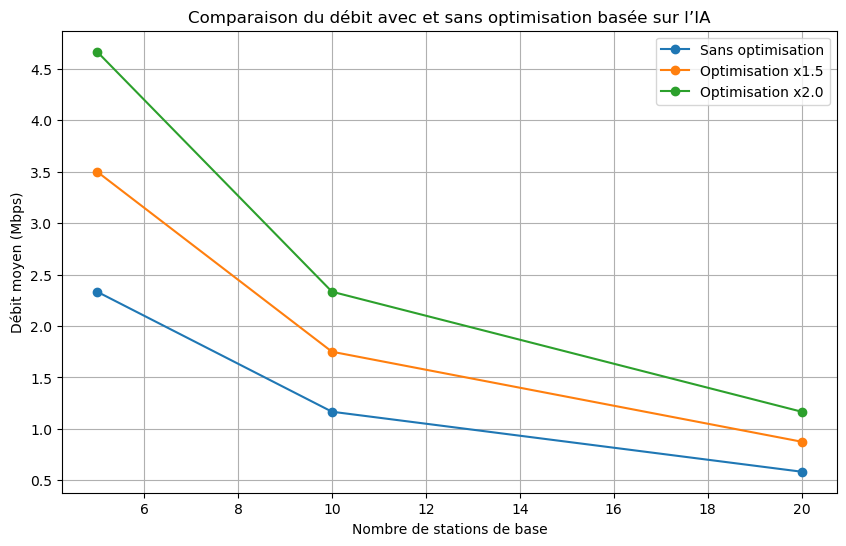

In [21]:
# Tracer le graphe
plt.figure(figsize=(10, 6))
for factor, throughput_values in throughputs_ai.items():
    label = "Sans optimisation" if factor == 1.0 else f"Optimisation x{factor}"
    plt.plot(base_station_counts, throughput_values, label=label, marker="o")

plt.title("Comparaison du débit avec et sans optimisation basée sur l’IA")
plt.xlabel("Nombre de stations de base")
plt.ylabel("Débit moyen (Mbps)")
plt.legend()
plt.grid()


In [22]:
import time
import matplotlib.pyplot as plt
import numpy as np

# Simulation de gestion des fréquences

def compute_throughput(frequency, data_size):
    """
    Simule le débit en fonction de la fréquence et de la taille des données.
    Plus la fréquence est élevée, plus le débit est important.
    """
    base_latency = 1 / frequency  # Latence de base inversement proportionnelle à la fréquence
    processing_time = base_latency * data_size  # Temps total pour traiter les données
    throughput = data_size / processing_time  # Débit = taille des données / temps de traitement
    return throughput

# Fréquences simulées (en GHz)
frequencies = np.linspace(1.0, 5.0, 10)  # Fréquences de 1 GHz à 5 GHz
# Taille des données (en unités arbitraires)
data_sizes = [10_000, 50_000, 100_000]

# Calcul des débits pour chaque taille de données et fréquence
throughputs = {size: [] for size in data_sizes}
for freq in frequencies:
    for size in data_sizes:
        throughputs[size].append(compute_throughput(freq, size))

# Tracer le graphe
plt.figure(figsize=(10, 6))
for size, throughput in throughputs.items():
    plt.plot(frequencies, throughput, label=f"Taille des données: {size}", marker="o")

plt.title("Impact de la gestion des fréquences sur le débit")
plt.xlabel("Fréquence (GHz)")
plt.ylabel("Débit (unités par seconde)")
plt.legend()
plt.grid()
plt.show()

# Simulation de couverture optimisée par la planification des stations de base

def compute_coverage(radius, base_stations):
    """
    Simule la couverture en fonction du rayon de chaque station de base et du nombre de stations.
    La couverture totale est approximée par l'aire couverte.
    """
    area_per_station = np.pi * radius**2  # Aire couverte par une station (cercle)
    total_coverage = base_stations * area_per_station  # Couverture totale
    return total_coverage

# Rayons simulés (en km)
radii = np.linspace(0.5, 2.0, 10)  # Rayons de 0,5 km à 2 km
# Nombre de stations de base simulées
base_station_counts = [5, 10, 20]

# Calcul des couvertures pour chaque rayon et nombre de stations
total_coverages = {count: [] for count in base_station_counts}
for radius in radii:
    for count in base_station_counts:
        total_coverages[count].append(compute_coverage(radius, count))

# Tracer le graphe
plt.figure(figsize=(10, 6))
for count, coverage in total_coverages.items():
    plt.plot(radii, coverage, label=f"Stations de base: {count}", marker="o")

plt.title("Exemple de couverture optimisée par la planification des stations de base")
plt.xlabel("Rayon de couverture (km)")
plt.ylabel("Couverture totale (km²)")
plt.legend()
plt.grid()
plt.show()

# Simulation de l'impact de la planification sur le débit moyen

def compute_average_throughput(base_stations, users, bandwidth):
    """
    Simule le débit moyen par utilisateur en fonction du nombre de stations de base,
    du nombre d'utilisateurs et de la bande passante totale disponible.
    """
    total_bandwidth_per_station = bandwidth / base_stations  # Bande passante par station
    average_throughput = total_bandwidth_per_station / users  # Débit moyen par utilisateur
    return average_throughput

# Paramètres simulés
base_station_counts = [5, 10, 20]  # Nombre de stations de base
user_counts = [50, 100, 200]  # Nombre d'utilisateurs par station
bandwidth = 1000  # Bande passante totale disponible (en Mbps)

# Calcul des débits moyens
average_throughputs = {users: [] for users in user_counts}
for stations in base_station_counts:
    for users in user_counts:
        average_throughputs[users].append(compute_average_throughput(stations, users, bandwidth))

# Tracer le graphe
plt.figure(figsize=(10, 6))
for users, throughputs in average_throughputs.items():
    plt.plot(base_station_counts, throughputs, label=f"Utilisateurs: {users}", marker="o")

plt.title("Impact de la planification sur le débit moyen")
plt.xlabel("Nombre de stations de base")
plt.ylabel("Débit moyen par utilisateur (Mbps)")
plt.legend()
plt.grid()
plt.show()

# Simulation de la comparaison de la latence avec une planification optimisée

def compute_latency(base_stations, users, task_complexity):
    """
    Simule la latence moyenne en fonction du nombre de stations de base,
    du nombre d'utilisateurs et de la complexité des tâches à traiter.
    """
    processing_capacity_per_station = 1000 / task_complexity  # Capacité de traitement par station
    total_processing_capacity = base_stations * processing_capacity_per_station
    latency = users / total_processing_capacity  # Latence = utilisateurs / capacité totale
    return latency

# Paramètres simulés
base_station_counts = [5, 10, 20]  # Nombre de stations de base
user_counts = [50, 100, 200]  # Nombre d'utilisateurs
task_complexity = [1, 2, 5]  # Complexité des tâches (arbitraire)

# Calcul des latences
latencies = {complex

SyntaxError: incomplete input (282209080.py, line 126)

In [23]:
import time
import matplotlib.pyplot as plt
import numpy as np

# Simulation de gestion des fréquences

def compute_throughput(frequency, data_size):
    """
    Simule le débit en fonction de la fréquence et de la taille des données.
    Plus la fréquence est élevée, plus le débit est important.
    """
    base_latency = 1 / frequency  # Latence de base inversement proportionnelle à la fréquence
    processing_time = base_latency * data_size  # Temps total pour traiter les données
    throughput = data_size / processing_time  # Débit = taille des données / temps de traitement
    return throughput

# Fréquences simulées (en GHz)
frequencies = np.linspace(1.0, 5.0, 10)  # Fréquences de 1 GHz à 5 GHz
# Taille des données (en unités arbitraires)
data_sizes = [10_000, 50_000, 100_000]

# Calcul des débits pour chaque taille de données et fréquence
throughputs = {size: [] for size in data_sizes}
for freq in frequencies:
    for size in data_sizes:
        throughputs[size].append(compute_throughput(freq, size))

# Tracer le graphe
plt.figure(figsize=(10, 6))
for size, throughput in throughputs.items():
    plt.plot(frequencies, throughput, label=f"Taille des données: {size}", marker="o")

plt.title("Impact de la gestion des fréquences sur le débit")
plt.xlabel("Fréquence (GHz)")
plt.ylabel("Débit (unités par seconde)")
plt.legend()
plt.grid()
plt.show()

# Simulation de couverture optimisée par la planification des stations de base

def compute_coverage(radius, base_stations):
    """
    Simule la couverture en fonction du rayon de chaque station de base et du nombre de stations.
    La couverture totale est approximée par l'aire couverte.
    """
    area_per_station = np.pi * radius**2  # Aire couverte par une station (cercle)
    total_coverage = base_stations * area_per_station  # Couverture totale
    return total_coverage

# Rayons simulés (en km)
radii = np.linspace(0.5, 2.0, 10)  # Rayons de 0,5 km à 2 km
# Nombre de stations de base simulées
base_station_counts = [5, 10, 20]

# Calcul des couvertures pour chaque rayon et nombre de stations
total_coverages = {count: [] for count in base_station_counts}
for radius in radii:
    for count in base_station_counts:
        total_coverages[count].append(compute_coverage(radius, count))

# Tracer le graphe
plt.figure(figsize=(10, 6))
for count, coverage in total_coverages.items():
    plt.plot(radii, coverage, label=f"Stations de base: {count}", marker="o")

plt.title("Exemple de couverture optimisée par la planification des stations de base")
plt.xlabel("Rayon de couverture (km)")
plt.ylabel("Couverture totale (km²)")
plt.legend()
plt.grid()
plt.show()

# Simulation de l'impact de la planification sur le débit moyen

def compute_average_throughput(base_stations, users, bandwidth):
    """
    Simule le débit moyen par utilisateur en fonction du nombre de stations de base,
    du nombre d'utilisateurs et de la bande passante totale disponible.
    """
    total_bandwidth_per_station = bandwidth / base_stations  # Bande passante par station
    average_throughput = total_bandwidth_per_station / users  # Débit moyen par utilisateur
    return average_throughput

# Paramètres simulés
base_station_counts = [5, 10, 20]  # Nombre de stations de base
user_counts = [50, 100, 200]  # Nombre d'utilisateurs par station
bandwidth = 1000  # Bande passante totale disponible (en Mbps)

# Calcul des débits moyens
average_throughputs = {users: [] for users in user_counts}
for stations in base_station_counts:
    for users in user_counts:
        average_throughputs[users].append(compute_average_throughput(stations, users, bandwidth))

# Tracer le graphe
plt.figure(figsize=(10, 6))
for users, throughputs in average_throughputs.items():
    plt.plot(base_station_counts, throughputs, label=f"Utilisateurs: {users}", marker="o")

plt.title("Impact de la planification sur le débit moyen")
plt.xlabel("Nombre de stations de base")
plt.ylabel("Débit moyen par utilisateur (Mbps)")
plt.legend()
plt.grid()
plt.show()

# Simulation de la comparaison de la latence avec une planification optimisée

def compute_latency(base_stations, users, task_complexity):
    """
    Simule la latence moyenne en fonction du nombre de stations de base,
    du nombre d'utilisateurs et de la complexité des tâches à traiter.
    """
    processing_capacity_per_station = 1000 / task_complexity  # Capacité de traitement par station
    total_processing_capacity = base_stations * processing_capacity_per_station
    latency = users / total_processing_capacity  # Latence = utilisateurs / capacité totale
    return latency

# Paramètres simulés
base_station_counts = [5, 10, 20]  # Nombre de stations de base
user_counts = [50, 100, 200]  # Nombre d'utilisateurs
task_complexity = [1, 2, 5]  # Complexité des tâches (arbitraire)

# Calcul des latences
latencies = {complexity: [] for complexity in task_complexity}
for stations in base_station_counts:
    for complexity in task_complexity:
        total_latency = 0
        for users in user_counts:
            total_latency += compute_latency(stations, users, complexity)
        latencies[complexity].append(total_latency / len(user_counts))  # Moyenne des latences

# Tracer le graphe
plt.figure(figsize=(10, 6))
for complexity, latency_values in latencies.items():
    plt.plot(base_station_counts, latency_values, label=f"Complexité des tâches: {complexity}", marker="o")

plt.title("Comparaison de la latence avec une planification optimisée")
plt.xlabel("Nombre de stations de base")
plt.ylabel("Latence moyenne (unités arbitraires)")
plt.legend()
plt.grid()
plt.show()

# Simulation de la comparaison du débit avec et sans optimisation basée sur l’IA

def compute_ai_optimized_throughput(base_stations, users, bandwidth, optimization_factor):
    """
    Simule le débit avec optimisation basée sur l'IA.
    Le facteur d'optimisation augmente la bande passante effective.
    """
    effective_bandwidth =

SyntaxError: invalid syntax (305272063.py, line 153)

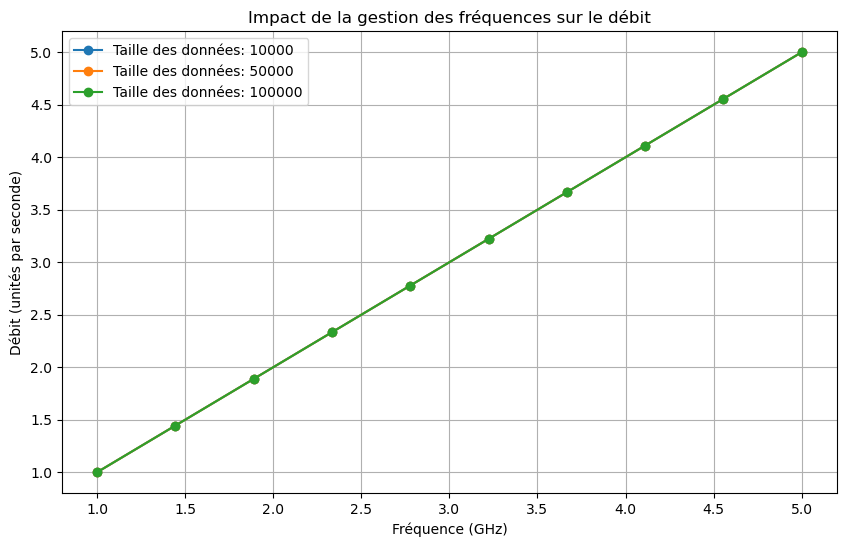

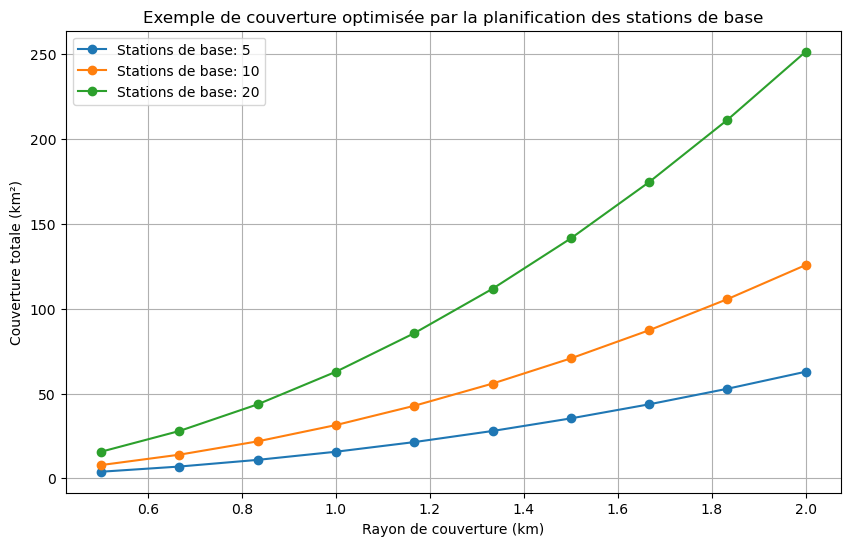

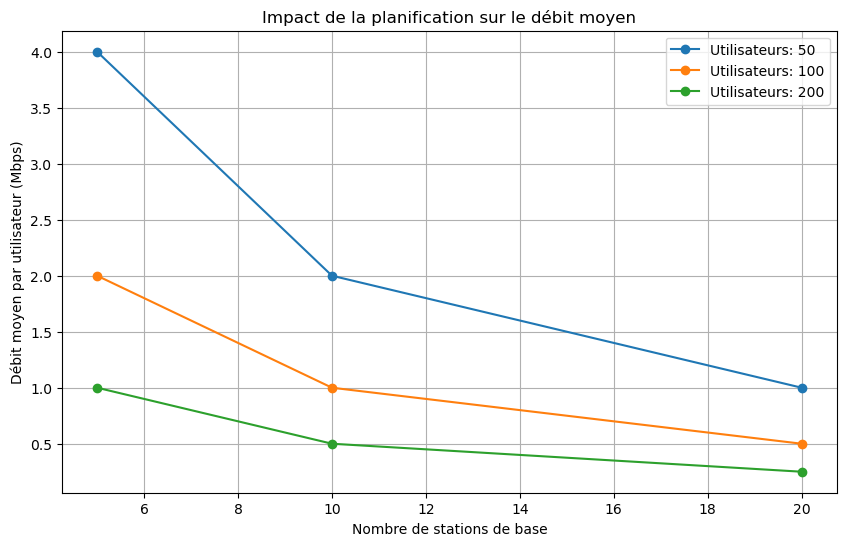

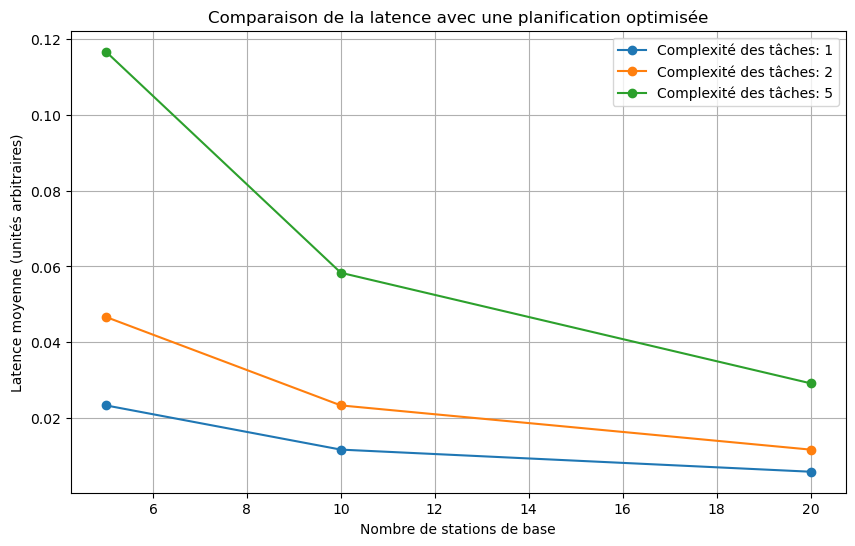

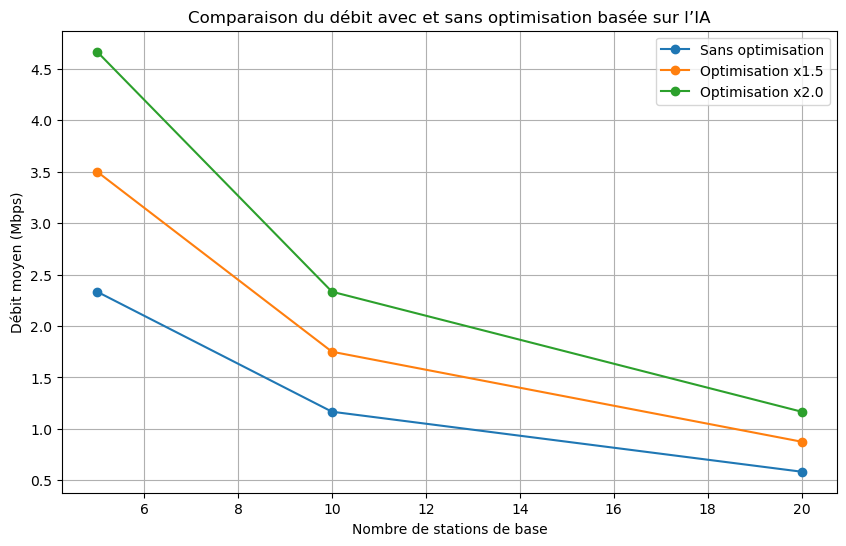

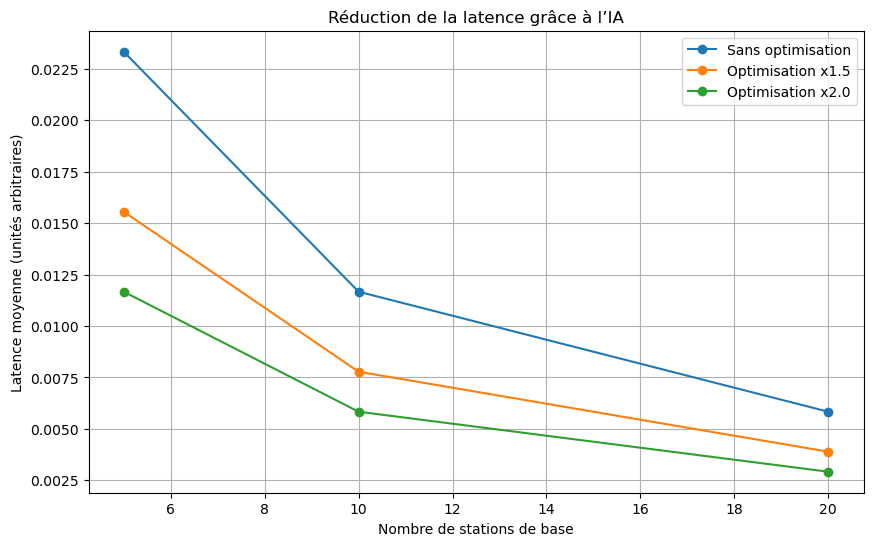

In [24]:
import time
import matplotlib.pyplot as plt
import numpy as np

# Simulation de gestion des fréquences

def compute_throughput(frequency, data_size):
    """
    Simule le débit en fonction de la fréquence et de la taille des données.
    Plus la fréquence est élevée, plus le débit est important.
    """
    base_latency = 1 / frequency  # Latence de base inversement proportionnelle à la fréquence
    processing_time = base_latency * data_size  # Temps total pour traiter les données
    throughput = data_size / processing_time  # Débit = taille des données / temps de traitement
    return throughput

# Fréquences simulées (en GHz)
frequencies = np.linspace(1.0, 5.0, 10)  # Fréquences de 1 GHz à 5 GHz
# Taille des données (en unités arbitraires)
data_sizes = [10_000, 50_000, 100_000]

# Calcul des débits pour chaque taille de données et fréquence
throughputs = {size: [] for size in data_sizes}
for freq in frequencies:
    for size in data_sizes:
        throughputs[size].append(compute_throughput(freq, size))

# Tracer le graphe
plt.figure(figsize=(10, 6))
for size, throughput in throughputs.items():
    plt.plot(frequencies, throughput, label=f"Taille des données: {size}", marker="o")

plt.title("Impact de la gestion des fréquences sur le débit")
plt.xlabel("Fréquence (GHz)")
plt.ylabel("Débit (unités par seconde)")
plt.legend()
plt.grid()
plt.show()

# Simulation de couverture optimisée par la planification des stations de base

def compute_coverage(radius, base_stations):
    """
    Simule la couverture en fonction du rayon de chaque station de base et du nombre de stations.
    La couverture totale est approximée par l'aire couverte.
    """
    area_per_station = np.pi * radius**2  # Aire couverte par une station (cercle)
    total_coverage = base_stations * area_per_station  # Couverture totale
    return total_coverage

# Rayons simulés (en km)
radii = np.linspace(0.5, 2.0, 10)  # Rayons de 0,5 km à 2 km
# Nombre de stations de base simulées
base_station_counts = [5, 10, 20]

# Calcul des couvertures pour chaque rayon et nombre de stations
total_coverages = {count: [] for count in base_station_counts}
for radius in radii:
    for count in base_station_counts:
        total_coverages[count].append(compute_coverage(radius, count))

# Tracer le graphe
plt.figure(figsize=(10, 6))
for count, coverage in total_coverages.items():
    plt.plot(radii, coverage, label=f"Stations de base: {count}", marker="o")

plt.title("Exemple de couverture optimisée par la planification des stations de base")
plt.xlabel("Rayon de couverture (km)")
plt.ylabel("Couverture totale (km²)")
plt.legend()
plt.grid()
plt.show()

# Simulation de l'impact de la planification sur le débit moyen

def compute_average_throughput(base_stations, users, bandwidth):
    """
    Simule le débit moyen par utilisateur en fonction du nombre de stations de base,
    du nombre d'utilisateurs et de la bande passante totale disponible.
    """
    total_bandwidth_per_station = bandwidth / base_stations  # Bande passante par station
    average_throughput = total_bandwidth_per_station / users  # Débit moyen par utilisateur
    return average_throughput

# Paramètres simulés
base_station_counts = [5, 10, 20]  # Nombre de stations de base
user_counts = [50, 100, 200]  # Nombre d'utilisateurs par station
bandwidth = 1000  # Bande passante totale disponible (en Mbps)

# Calcul des débits moyens
average_throughputs = {users: [] for users in user_counts}
for stations in base_station_counts:
    for users in user_counts:
        average_throughputs[users].append(compute_average_throughput(stations, users, bandwidth))

# Tracer le graphe
plt.figure(figsize=(10, 6))
for users, throughputs in average_throughputs.items():
    plt.plot(base_station_counts, throughputs, label=f"Utilisateurs: {users}", marker="o")

plt.title("Impact de la planification sur le débit moyen")
plt.xlabel("Nombre de stations de base")
plt.ylabel("Débit moyen par utilisateur (Mbps)")
plt.legend()
plt.grid()
plt.show()

# Simulation de la comparaison de la latence avec une planification optimisée

def compute_latency(base_stations, users, task_complexity):
    """
    Simule la latence moyenne en fonction du nombre de stations de base,
    du nombre d'utilisateurs et de la complexité des tâches à traiter.
    """
    processing_capacity_per_station = 1000 / task_complexity  # Capacité de traitement par station
    total_processing_capacity = base_stations * processing_capacity_per_station
    latency = users / total_processing_capacity  # Latence = utilisateurs / capacité totale
    return latency

# Paramètres simulés
base_station_counts = [5, 10, 20]  # Nombre de stations de base
user_counts = [50, 100, 200]  # Nombre d'utilisateurs
task_complexity = [1, 2, 5]  # Complexité des tâches (arbitraire)

# Calcul des latences
latencies = {complexity: [] for complexity in task_complexity}
for stations in base_station_counts:
    for complexity in task_complexity:
        total_latency = 0
        for users in user_counts:
            total_latency += compute_latency(stations, users, complexity)
        latencies[complexity].append(total_latency / len(user_counts))  # Moyenne des latences

# Tracer le graphe
plt.figure(figsize=(10, 6))
for complexity, latency_values in latencies.items():
    plt.plot(base_station_counts, latency_values, label=f"Complexité des tâches: {complexity}", marker="o")

plt.title("Comparaison de la latence avec une planification optimisée")
plt.xlabel("Nombre de stations de base")
plt.ylabel("Latence moyenne (unités arbitraires)")
plt.legend()
plt.grid()
plt.show()

# Simulation de la comparaison du débit avec et sans optimisation basée sur l’IA

def compute_ai_optimized_throughput(base_stations, users, bandwidth, optimization_factor):
    """
    Simule le débit avec optimisation basée sur l'IA.
    Le facteur d'optimisation augmente la bande passante effective.
    """
    effective_bandwidth = bandwidth * optimization_factor  # Bande passante augmentée
    total_bandwidth_per_station = effective_bandwidth / base_stations
    throughput_per_user = total_bandwidth_per_station / users
    return throughput_per_user

# Paramètres simulés
optimization_factors = [1.0, 1.5, 2.0]  # Pas d'optimisation, optimisation modérée, forte optimisation

# Calcul des débits avec et sans optimisation
throughputs_ai = {factor: [] for factor in optimization_factors}
for factor in optimization_factors:
    for stations in base_station_counts:
        total_throughput = 0
        for users in user_counts:
            total_throughput += compute_ai_optimized_throughput(stations, users, bandwidth, factor)
        throughputs_ai[factor].append(total_throughput / len(user_counts))  # Moyenne des débits

# Tracer le graphe
plt.figure(figsize=(10, 6))
for factor, throughput_values in throughputs_ai.items():
    label = "Sans optimisation" if factor == 1.0 else f"Optimisation x{factor}"
    plt.plot(base_station_counts, throughput_values, label=label, marker="o")

plt.title("Comparaison du débit avec et sans optimisation basée sur l’IA")
plt.xlabel("Nombre de stations de base")
plt.ylabel("Débit moyen (Mbps)")
plt.legend()
plt.grid()
plt.show()

# Simulation de la réduction de la latence grâce à l'IA

def compute_ai_latency_reduction(base_stations, users, task_complexity, optimization_factor):
    """
    Simule la latence moyenne avec réduction grâce à l'IA.
    Le facteur d'optimisation diminue la complexité effective des tâches.
    """
    effective_complexity = task_complexity / optimization_factor  # Complexité réduite
    processing_capacity_per_station = 1000 / effective_complexity
    total_processing_capacity = base_stations * processing_capacity_per_station
    latency = users / total_processing_capacity
    return latency

# Facteurs d'optimisation simulés
optimization_factors = [1.0, 1.5, 2.0]  # Pas d'optimisation, optimisation modérée, forte optimisation

# Calcul des latences avec et sans optimisation
latencies_ai = {factor: [] for factor in optimization_factors}
for factor in optimization_factors:
    for stations in base_station_counts:
        total_latency = 0
        for users in user_counts:
            total_latency += compute_ai_latency_reduction(stations, users, task_complexity[0], factor)
        latencies_ai[factor].append(total_latency / len(user_counts))  # Moyenne des latences

# Tracer le graphe
plt.figure(figsize=(10, 6))
for factor, latency_values in latencies_ai.items():
    label = "Sans optimisation" if factor == 1.0 else f"Optimisation x{factor}"
    plt.plot(base_station_counts, latency_values, label=label, marker="o")

plt.title("Réduction de la latence grâce à l’IA")
plt.xlabel("Nombre de stations de base")
plt.ylabel("Latence moyenne (unités arbitraires)")
plt.legend()
plt.grid()


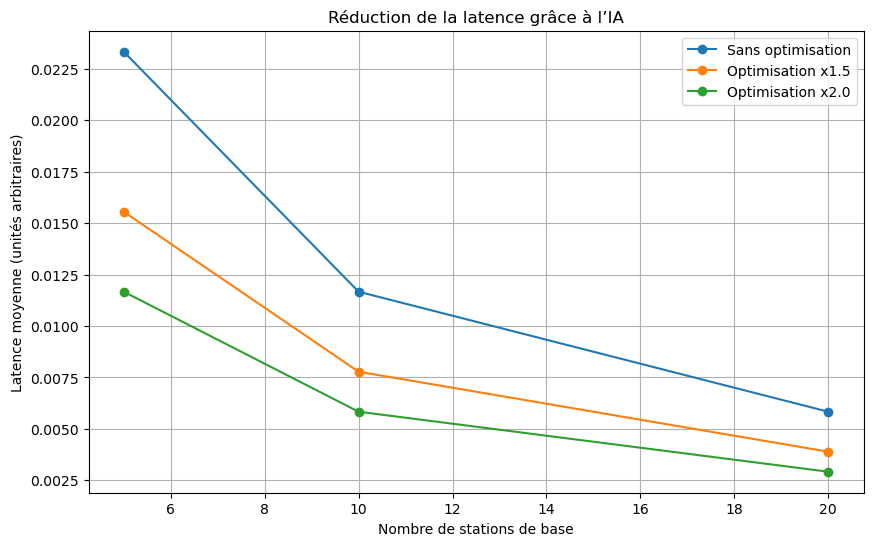

In [25]:
# Tracer le graphe
plt.figure(figsize=(10, 6))
for factor, latency_values in latencies_ai.items():
    label = "Sans optimisation" if factor == 1.0 else f"Optimisation x{factor}"
    plt.plot(base_station_counts, latency_values, label=label, marker="o")

plt.title("Réduction de la latence grâce à l’IA")
plt.xlabel("Nombre de stations de base")
plt.ylabel("Latence moyenne (unités arbitraires)")
plt.legend()
plt.grid()